# 環境設定

In [ ]:
import sys
!{sys.executable} --version
!{sys.executable} -m pip install -U numpy==1.26.4
import os
os._exit(0)

In [ ]:
import sys
!{sys.executable} -m pip install -U ray==2.5.0
import ray
print(ray.__version__)

In [ ]:
import sys
!{sys.executable} -m pip install -U monai==1.2.0
import monai
print(monai.__version__)

In [ ]:
!{sys.executable} -m pip install -U ml_collections

In [ ]:
!git clone https://github.com/kairaun/Sam.git

In [ ]:
%cd ./Sam
! ls
! head pyproject.toml
!pip install -e .
import os
os._exit(0)

In [ ]:
import sys
!{sys.executable} -m pip install -U --no-deps monailabel
import monailabel
print(monailabel.__version__)

In [ ]:
# Clone the project
!git clone https://github.com/kairaun/CardiacSegV2.git

In [ ]:
# Install the Environment
! sudo chmod 700 /content/CardiacSegV2/setup.sh
! /content/CardiacSegV2/setup.sh
! pip install gdown==4.6.0

In [ ]:
# Modify the code
! sed -i '8c \\    os.makedirs(\"/content/CardiacSegV2/\"+data_dir, exist_ok=True)' /content/CardiacSegV2/setup_dir.py
! sed -i '20c \\        os.makedirs(\"/content/CardiacSegV2/\"+model_exp_dir, exist_ok=True)' /content/CardiacSegV2/setup_dir.py
! sed -i '29c \\        os.makedirs("/content/CardiacSegV2/"+model_exp_dir, exist_ok=True)' /content/CardiacSegV2/setup_dir.py
! sed -i '3c sys.path.append(\"/content/CardiacSegV2\")' /content/CardiacSegV2/expers/infer.py
! sed -i '3c sys.path.append(\"/content/CardiacSegV2\")' /content/CardiacSegV2/expers/tune.py
! sed -i '36c ray.init(runtime_env={\"working_dir\": \"/content/CardiacSegV2\"})' /content/CardiacSegV2/expers/tune.py

In [ ]:
! python /content/CardiacSegV2/setup_dir.py

In [ ]:
!ls

In [ ]:
!pip install "pydantic<2.0"

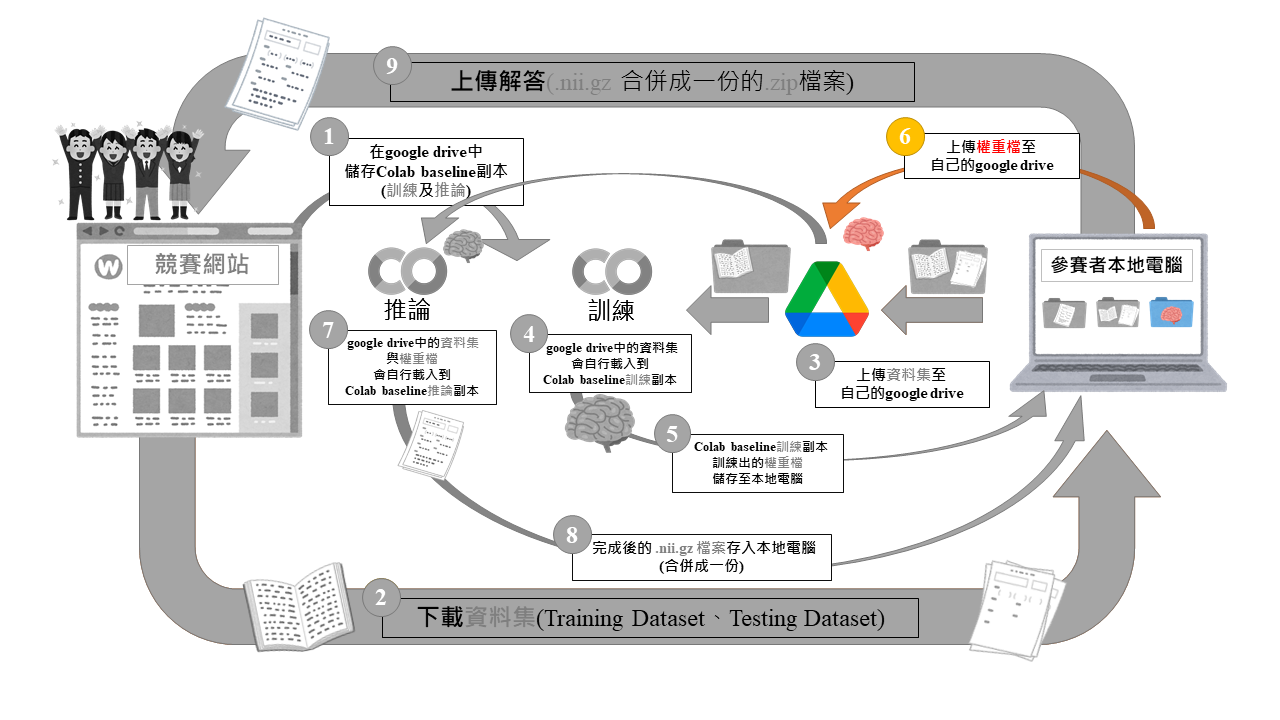

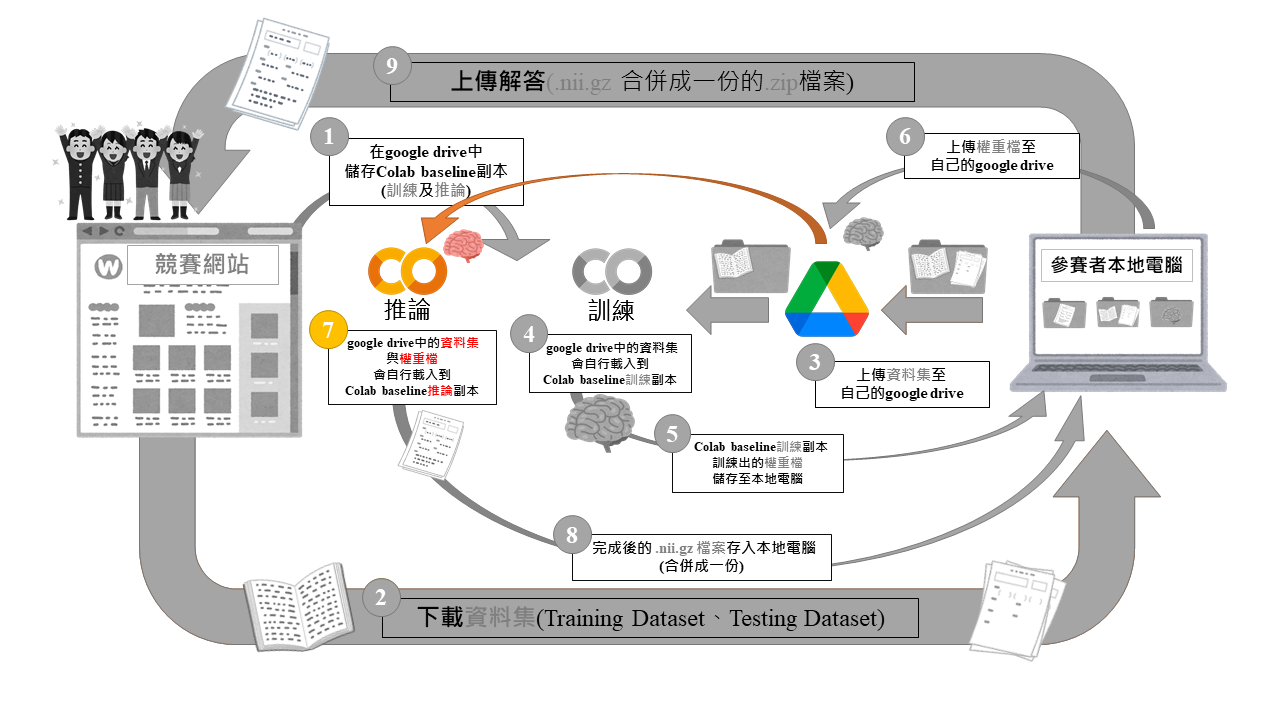

#執行推論 (儲存於Google Drive上)

In [8]:
workspace_dir = '/root/Document/ai_cup_ctseg/CardiacSegV2'
import sys
sys.path.append(workspace_dir)
import os
import importlib
from pathlib import PurePath

import pandas as pd
from ray import tune
from ray.train.trainer import BaseTrainer

#from datasets.chgh_dataset import get_data_dicts
#from data_utils.utils import get_pids_by_data_dicts


def get_tune_model_dir(root_exp_dir, exp_name):
    # experiment_path = os.path.join(root_exp_dir, exp_name)

    # print(f"Loading results from {experiment_path}...")

    # # restored_tuner = tune.Tuner.restore(
    # #     experiment_path, trainable=BaseTrainer, resume_errored=True)
    # # 727 fix
    # restored_tuner = tune.Tuner.restore(experiment_path, trainable='main')
    # result_grid = restored_tuner.get_results()

    # best_result = result_grid.get_best_result(metric="tt_dice", mode="max")
    # print(f"\nBest trial {best_result.metrics['trial_id']}: ")
    # print('config:', best_result.metrics['config'])
    # print('tt_dice:', best_result.metrics['tt_dice'])
    # # print('tt_iou:', best_result.metrics['tt_iou'])
    # if 'esc' in best_result.metrics:
    #     print('esc:', best_result.metrics['esc'])
    # print(f'best log dir:', best_result.log_dir)
    # model_dir = os.path.join(best_result.log_dir, 'models')
    model_dir = "/root/Document/ai_cup_ctseg/CardiacSegV2/exps/exps/unet3d/chgh/tune_results/exp_b7_9/main_2c646_00000_0_exp=exp_exp_b7_9_2025-09-19_14-16-27/models/"
    return model_dir


def get_tune_dir(exp_dir):
    restored_tuner = tune.Tuner.restore(exp_dir)
    result_grid = restored_tuner.get_results()
    best_result = result_grid.get_best_result(metric="tt_dice", mode="max")
    return best_result.log_dir


def get_data_path(data_dir, data_name, pid):
    dataset = importlib.import_module(f'datasets.{data_name}_dataset')
    _get_data_dicts = getattr(dataset, 'get_data_dicts', None)
    data_dicts = _get_data_dicts(data_dir)
    pids = get_pids_by_data_dicts(data_dicts)
    idx = pids.index(pid)
    return data_dicts[idx]


def get_pred_path(root_dir, exp_name, img_pth):
    return os.path.join(
        root_dir,
        'infers',
        exp_name,
        PurePath(img_pth).parts[-1]
    )


def get_eval_csv_path(root_dir):
    return os.path.join(
        root_dir,
        'evals',
        'best_model.csv'
    )


def get_eda_eval_csv_path(root_dir):
    return os.path.join(
        root_dir,
        'eda_evals',
        'best_model.csv'
    )


def get_eval_val(csv_pth, pid):
    df = pd.read_csv(csv_pth)
    idx = df['patientId'] == pid
    if 'inf_diceLV' in df[idx]:
        return {
            'dice': df[idx].filter(regex=("inf_dice*")).T.mean().tolist()[0],
            'iou': df[idx].filter(regex=("inf_iou*")).T.mean().tolist()[0]
        }
    else:
        return {
            'dice': df[idx]['inf_diceC'].tolist()[0],
            'iou': df[idx]['inf_iouC'].tolist()[0]
        }


def get_slice(img, slice_idx, mode, is_trans):
    '''
    mode: a, c, s
    '''
    if mode == 'a':
        img = img[:, :, slice_idx]
    elif mode == 's':
        img = img[:, slice_idx, :]
    else:
        img = img[slice_idx, :, :]

    if is_trans:
        return img.T
    else:
        return img


def get_img_lbl_preds(data, exp_names, slice_idxs, mode='a', is_trans=False):
    '''
    mode: a, c, s
    '''
    preds = []
    imgs = []
    lbls = []
    for slice_idx in slice_idxs:
        pred_ls = []
        for exp_name in exp_names:
            pred_ls.append(
                get_slice(data[exp_name], slice_idx, mode, is_trans))
        preds.append(pred_ls)
        imgs.append(get_slice(data['image'], slice_idx, mode, is_trans))
        lbls.append(get_slice(data['label'], slice_idx, mode, is_trans))
    return imgs, lbls, preds


# 確定Google Drive內容

In [3]:
import os
pred_img = []
for root, dirs, files in os.walk("/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/", topdown=False):
  for name in files:
    pred_img.append(os.path.join(root, name))
    print(os.path.join(root, name))

/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0083.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0073.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0091.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0074.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0069.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0078.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0072.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0060.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0081.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0062.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0098.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0051.nii.gz
/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patie

# 下載預訓練檔

In [ ]:
import gdown
os.makedirs('/content/CardiacSegV2/exps/exps/unet3d/chgh/tune_results/AICUP_training', exist_ok=True)

#請在[位置id]處放上你的權重檔位置
# https://drive.google.com/file/d/[位置id]/view?usp=sharing
gdown.download("https://drive.google.com/u/0/uc?id=[位置id]&export=download","/content/CardiacSegV2/exps/exps/unet3d/chgh/tune_results/AICUP_training.zip")

! unzip "/content/CardiacSegV2/exps/exps/unet3d/chgh/tune_results/AICUP_training.zip" -d "/content/CardiacSegV2/exps/exps/unet3d/chgh/tune_results/"

# 推論設定

In [4]:
import os

workspace_dir = '/root/Document/ai_cup_ctseg/CardiacSegV2'
model_name = 'unet3d' #unet3d
data_name = 'chgh'
#sub_data_dir_name = 'dataset_3'
exp_name = 'AICUP_training'
data_dict_file_name = 'AICUP_training.json'

# set exp dir
root_exp_dir = os.path.join(workspace_dir,'exps','exps',model_name,data_name,'tune_results')

# set data dir
root_data_dir = os.path.join(workspace_dir,'dataset',data_name)
#data_dir = os.path.join(root_data_dir, sub_data_dir_name)
data_dir = os.path.join(root_data_dir)
# data dict json path
data_dicts_json = os.path.join(workspace_dir, 'exps', 'data_dicts', data_name, data_dict_file_name)

# set model, log, eval dir
model_dir = os.path.join('./', 'models')
log_dir = os.path.join('./', 'logs')
eval_dir = os.path.join('./', 'evals')
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(eval_dir, exist_ok=True)


# model path
best_checkpoint = os.path.join(model_dir, 'best_model.pth')
final_checkpoint = os.path.join(model_dir, 'final_model.pth')

# mkdir root exp dir
os.makedirs(root_exp_dir, exist_ok=True)

In [10]:
import sys
workspace_dir = '/root/Document/ai_cup_ctseg/CardiacSegV2'
sys.path.append(workspace_dir)

import os
#from expers.infer_utils import get_tune_model_dir, get_data_path, get_pred_path

model_name = "unet3d" #unet3d
data_name = 'chgh'
exp_name = 'exp_b7_9'

root_exp_dir = os.path.join(workspace_dir,'exps','exps',model_name,data_name,'tune_results')
model_dir = get_tune_model_dir(root_exp_dir, exp_name)
best_checkpoint = os.path.join(model_dir, 'best_model.pth')
infer_dir = os.path.join('/root/Document/ai_cup_ctseg/myo_pred',"chgh","infer")
#

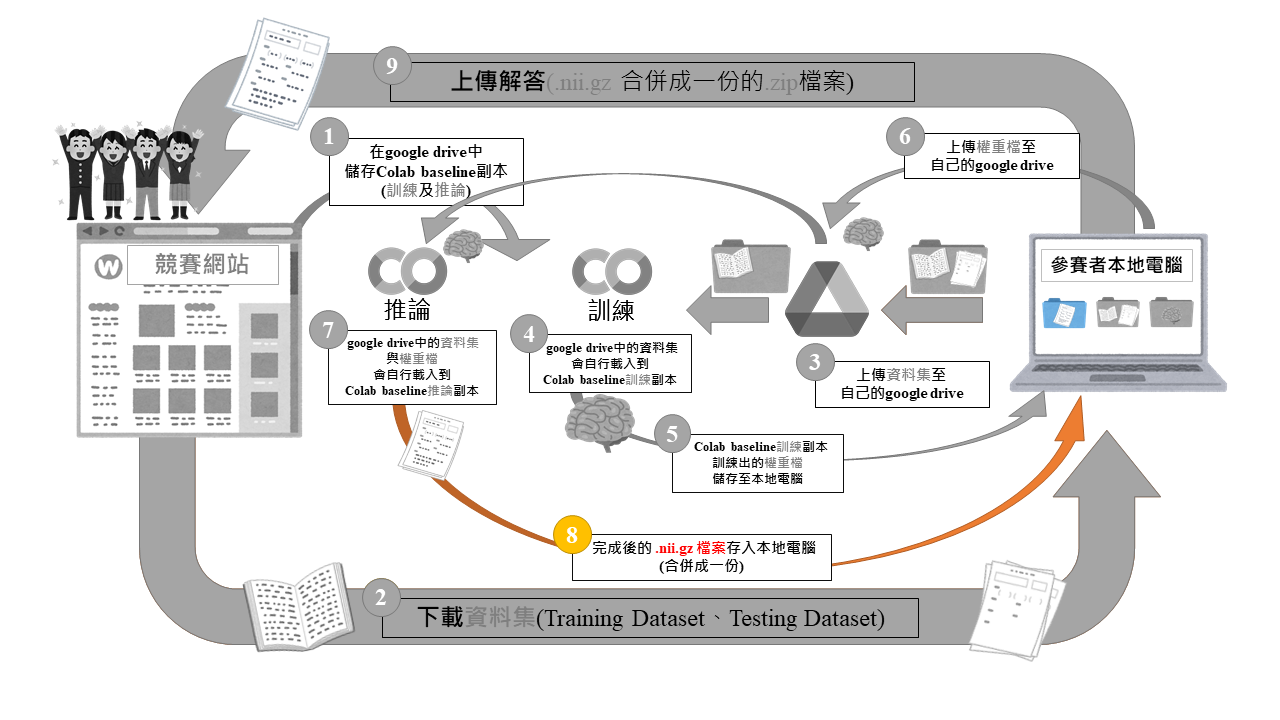

In [11]:
print(model_dir)

/root/Document/ai_cup_ctseg/CardiacSegV2/exps/exps/unet3d/chgh/tune_results/exp_b7_9/main_2c646_00000_0_exp=exp_exp_b7_9_2025-09-19_14-16-27/models/


# 執行推論

In [12]:
for img_pth in pred_img:
  !python ../CardiacSegV2/expers/infer.py \
  --model_name={model_name} \
  --data_name={data_name} \
  --data_dir={data_dir} \
  --model_dir={model_dir} \
  --infer_dir={infer_dir} \
  --checkpoint={best_checkpoint} \
  --img_pth={img_pth} \
  --out_channels=4 \
  --patch_size=2 \
  --feature_size=48 \
  --drop_rate=0.1 \
  --depths 3 3 9 3 \
  --kernel_size 7 \
  --exp_rate 4 \
  --norm_name='layer' \
  --a_min=-42 \
  --a_max=423 \
  --space_x=0.7 \
  --space_y=0.7 \
  --space_z=1.0 \
  --roi_x=128 \
  --roi_y=128 \
  --roi_z=128 \
  --infer_post_process

cuda is available
model: unet3d
=> loaded checkpoint '/root/Document/ai_cup_ctseg/CardiacSegV2/exps/exps/unet3d/chgh/tune_results/exp_b7_9/main_2c646_00000_0_exp=exp_exp_b7_9_2025-09-19_14-16-27/models/best_model.pth')
infer data: {'image': '/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/pred/patient0083.nii.gz'}
/root/miniconda3/envs/ctseg/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/root/miniconda3/envs/ctseg/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transf

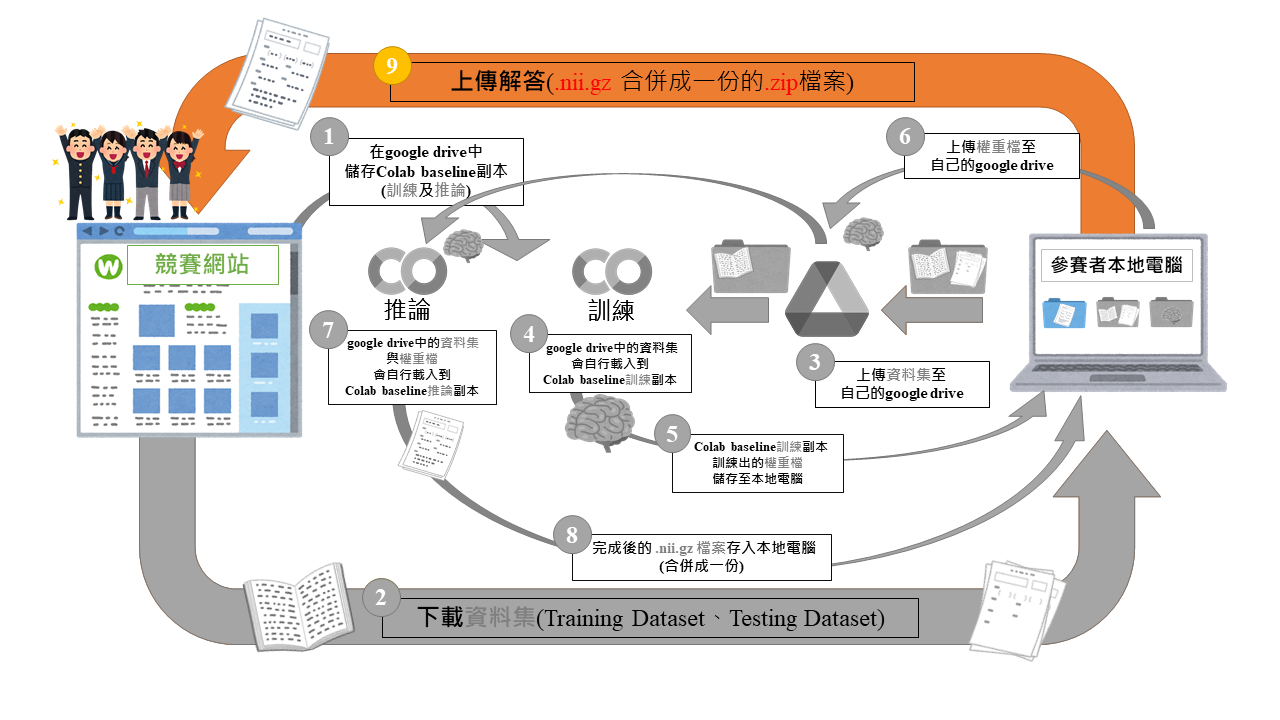

In [13]:
import os
import glob
import sys

# 定義要操作的目錄路徑
# 根據您的需求，這個路徑是固定的
source_dir = '/root/Document/ai_cup_ctseg/myo_pred/chgh/infer'
 
def rename_nii_gz_files(directory):
    """
    讀取指定目錄下的所有 .nii.gz 文件，並將其重新命名為 '原檔名_predict.nii.gz'。
    
    Args:
        directory (str): 包含文件的目錄路徑。
    """
    
    # 檢查目錄是否存在
    if not os.path.isdir(directory):
        print(f"錯誤：指定的目錄不存在或無法訪問: {directory}")
        return

    # 搜尋所有 .nii.gz 文件
    # 使用 glob.glob 來尋找所有匹配的文件
    search_path = os.path.join(directory, "*.nii.gz")
    nii_files = glob.glob(search_path)
    
    if not nii_files:
        print(f"在目錄 {directory} 中未找到任何 .nii.gz 文件。")
        return

    print(f"在目錄 {directory} 中找到 {len(nii_files)} 個 .nii.gz 文件，開始重命名...")

    for old_filepath in nii_files:
        # 1. 取得舊文件名 (例如: image_001.nii.gz)
        old_filename = os.path.basename(old_filepath)
        
        # 2. 移除 .nii.gz 副檔名，取得基礎名稱 (例如: image_001)
        # os.path.splitext() 會將 .gz 視為第一個副檔名，因此需要連續使用兩次
        base_name, ext1 = os.path.splitext(old_filename) # base_name = 'image_001.nii', ext1 = '.gz'
        base_name, ext2 = os.path.splitext(base_name)   # base_name = 'image_001', ext2 = '.nii'
        
        # 3. 構造新的文件名 (例如: image_001_predict.nii.gz)
        # 保持原始的 .nii.gz 結構
        new_filename = f"{base_name}_predict{ext2}{ext1}"
        new_filepath = os.path.join(directory, new_filename)
        
        # 4. 執行重命名
        try:
            # 檢查新文件是否已經存在，避免覆蓋
            if os.path.exists(new_filepath):
                print(f"警告：新文件已存在，跳過重命名: {new_filename}")
                continue
                
            os.rename(old_filepath, new_filepath)
            print(f"重命名成功: {old_filename} -> {new_filename}")
        except OSError as e:
            print(f"重命名 {old_filename} 失敗: {e}")
            
    print("\n所有文件處理完畢。")

# 執行重命名操作
rename_nii_gz_files(source_dir)

在目錄 /root/Document/ai_cup_ctseg/myo_pred/chgh/infer 中找到 50 個 .nii.gz 文件，開始重命名...
重命名成功: patient0083.nii.gz -> patient0083_predict.nii.gz
重命名成功: patient0073.nii.gz -> patient0073_predict.nii.gz
重命名成功: patient0091.nii.gz -> patient0091_predict.nii.gz
重命名成功: patient0074.nii.gz -> patient0074_predict.nii.gz
重命名成功: patient0069.nii.gz -> patient0069_predict.nii.gz
重命名成功: patient0078.nii.gz -> patient0078_predict.nii.gz
重命名成功: patient0072.nii.gz -> patient0072_predict.nii.gz
重命名成功: patient0060.nii.gz -> patient0060_predict.nii.gz
重命名成功: patient0081.nii.gz -> patient0081_predict.nii.gz
重命名成功: patient0062.nii.gz -> patient0062_predict.nii.gz
重命名成功: patient0098.nii.gz -> patient0098_predict.nii.gz
重命名成功: patient0051.nii.gz -> patient0051_predict.nii.gz
重命名成功: patient0086.nii.gz -> patient0086_predict.nii.gz
重命名成功: patient0064.nii.gz -> patient0064_predict.nii.gz
重命名成功: patient0066.nii.gz -> patient0066_predict.nii.gz
重命名成功: patient0071.nii.gz -> patient0071_predict.nii.gz
重命名成功: patient0063.nii.

In [14]:
import os
import zipfile
import glob

# -----------------
# 1. 定義路徑
# -----------------

# 包含要壓縮的 .nii.gz 文件的目錄 (當前目錄)
source_dir = '/root/Document/ai_cup_ctseg/myo_pred/chgh/infer'

# 上一層目錄的路徑
# 使用 os.path.dirname() 獲取 source_dir 的父目錄
parent_dir = os.path.dirname(source_dir)

# 最終 zip 檔案的路徑和名稱
zip_filename = 'predict.zip'
zip_filepath = os.path.join(parent_dir, zip_filename)

# -----------------
# 2. 執行壓縮
# -----------------
def create_zip_archive(source_dir, zip_filepath):
    """
    將指定目錄下的所有文件壓縮到指定的 zip 檔案中。
    
    Args:
        source_dir (str): 要壓縮的文件的來源目錄。
        zip_filepath (str): 輸出 zip 檔案的完整路徑。
    """
    
    # 檢查來源目錄是否存在
    if not os.path.isdir(source_dir):
        print(f"錯誤：來源目錄不存在: {source_dir}")
        return

    # 確保目標 zip 檔案所在的父目錄存在 (這裡不需要，因為 parent_dir 應該存在)
    # os.makedirs(os.path.dirname(zip_filepath), exist_ok=True)

    print(f"開始壓縮目錄：{source_dir}")
    print(f"目標 zip 檔案：{zip_filepath}")
    
    # 使用 zipfile.ZipFile 建立 zip 檔案
    # 模式 'w' 表示寫入 (會覆蓋已存在的同名文件)
    try:
        with zipfile.ZipFile(zip_filepath, 'w', zipfile.ZIP_DEFLATED) as zipf:
            
            # 遍歷 source_dir 中的所有文件
            for filename in os.listdir(source_dir):
                file_path = os.path.join(source_dir, filename)
                
                # 只處理文件，忽略子目錄
                if os.path.isfile(file_path):
                    
                    # 關鍵步驟：
                    # 將文件寫入 zip 檔案，並指定在 zip 內部的名稱 (arcname)。
                    # 這裡我們只使用 basename (例如: image_001_predict.nii.gz)
                    # 這樣可以避免在 zip 檔案內部創建 'root/Document/...' 這樣的目錄結構。
                    arcname = filename 
                    
                    zipf.write(file_path, arcname)
                    print(f"  -> 已加入: {filename}")

        print(f"\n✅ 壓縮完成！檔案已儲存至：{zip_filepath}")

    except Exception as e:
        print(f"❌ 壓縮過程中發生錯誤: {e}")

# 執行函數
create_zip_archive(source_dir, zip_filepath)

開始壓縮目錄：/root/Document/ai_cup_ctseg/myo_pred/chgh/infer
目標 zip 檔案：/root/Document/ai_cup_ctseg/myo_pred/chgh/predict.zip
  -> 已加入: patient0067_predict.nii.gz
  -> 已加入: patient0093_predict.nii.gz
  -> 已加入: patient0091_predict.nii.gz
  -> 已加入: patient0077_predict.nii.gz
  -> 已加入: patient0061_predict.nii.gz
  -> 已加入: patient0071_predict.nii.gz
  -> 已加入: patient0086_predict.nii.gz
  -> 已加入: patient0058_predict.nii.gz
  -> 已加入: patient0062_predict.nii.gz
  -> 已加入: patient0072_predict.nii.gz
  -> 已加入: patient0051_predict.nii.gz
  -> 已加入: patient0054_predict.nii.gz
  -> 已加入: patient0069_predict.nii.gz
  -> 已加入: patient0097_predict.nii.gz
  -> 已加入: patient0080_predict.nii.gz
  -> 已加入: patient0074_predict.nii.gz
  -> 已加入: patient0094_predict.nii.gz
  -> 已加入: patient0092_predict.nii.gz
  -> 已加入: patient0083_predict.nii.gz
  -> 已加入: patient0052_predict.nii.gz
  -> 已加入: patient0099_predict.nii.gz
  -> 已加入: patient0079_predict.nii.gz
  -> 已加入: patient0084_predict.nii.gz
  -> 已加入: patient0078_predict.